In [1]:
# TEMP: Import lagom
# Not useful once lagom is installed
import sys
sys.path.append('/home/zuo/Code/lagom/')

### use functiontools.partial to set make_env function without argument but internally

In [18]:
import numpy as np

np.swapaxes()

<module 'numpy' from '/home/zuo/anaconda3/envs/RL_server/lib/python3.6/site-packages/numpy/__init__.py'>

# VecEnv

In [ ]:
import numpy as np
from multiprocessing import Process  # easier code than threading
from multiprocessing import Pipe  # Much faster than Queue


class CloudpickleWrapper(object):
    """
    Uses cloudpickle to serialize contents (otherwise multiprocessing tries to use pickle)
    """
    def __init__(self, x):
        self.x = x
        
    def __call__(self):
        return self.x()
    
    def __getstate__(self):
        import cloudpickle
        return cloudpickle.dumps(self.x)
    def __setstate__(self, ob):
        import pickle
        self.x = pickle.loads(ob)


def worker(child_conn, parent_conn, make_env):
    parent_conn.close()
    # Create an environment
    env = make_env()
    
    while True:
        cmd, data = child_conn.recv()
        if cmd == 'step':
            obs, reward, done, info = env.step(data)
            if done:
                obs = env.reset()  # TODO: why reset
            child_conn.send([obs, reward, done, info])
        elif cmd == 'reset':
            obs = env.reset()
            child_conn.send(obs)
        elif cmd == 'reset_task':
            obs = env.reset_task()
            child_conn.send(obs)
        elif cmd == 'close':
            child_conn.close()
            break
        elif cmd == 'get_spaces':
            child_conn.send([env.observation_space, env.action_space])
        else:
            raise NotImplementedError

class SubprocVecEnv(VecEnv):
    """
    Run a list of environment in subprocesses
    """
    def __init__(self, list_make_env):
        self.waiting = False
        self.closed = False
        self.num_envs = len(list_make_env)
        self.parent_conns, self.child_conns = zip(*[Pipe() for _ in range(self.num_envs)])
        self.processes = []
        for parent_conn, child_conn, make_env in zip(self.parent_conns, self.child_conns, list_make_env):
            self.processes.append(Process(target=worker, args=[child_conn, parent_conn, CloudpickleWrapper(make_env)]))  # TODO: CloudpickleWrapper make_env
        for process in self.processes:
            process.daemon = True  # if the main process crashes, we should not cause things to hang
            process.start()
        for conn in self.child_conns:
            conn.close()
        
        # Obtain observation and action spaces
        self.parent_conns[0].send(['get_spaces', None])
        observation_space, action_space = self.parent_conns[0].recv()
        super().__init__(self.num_envs, observation_space, action_space)
        
    def step_asyn(self, actions):
        for parent_conn, action in zip(self.parent_conns, actions):
            parent_conn.send(['step', action])
            
        self.waiting = True
        
    def step_wait(self):
        observations, rewards, dones, infos = zip(*[parent_conn.recv() for parent_conn in self.parent_conns])
        self.waiting = False
        return np.stack(observations), np.stack(rewards), np.stack(dones), infos
    
    def reset(self):
        for parent_conn in self.parent_conns:
            parent_conn.send(['reset', None])
        return np.stack([parent_conn.recv() for parent_conn in self.parent_conns])
    
    def reset_task(self):
        for parent_conn in self.parent_conns:
            parent_conn.send(['reset_task', None])
        return np.stack([parent_conn.recv() for parent_conn in self.parent_conns])
    
    def close(self):
        if self.closed:
            return
        if self.waiting:
            for parent_conn in self.parent_conns:
                parent_conn.recv()
        for parent_conn in self.parent_conns:
            parent_conn.send(['close', None])
        for process in self.processes:
            process.join()
        self.closed = True

# LSTM network

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim


import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt


np.random.seed(2)

T = 20
L = 1000
N = 100

x = np.empty((N, L), 'int64')
x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
data = np.sin(x/T).astype('float32')


class Sequence(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.lstm1 = nn.LSTMCell(1, 51)
        self.lstm2 = nn.LSTMCell(51, 51)
        self.linear = nn.Linear(51, 1)
        
    def forward(self, x, future=0):
        outputs = []
        batch_size, x_size = x.size()
        
        h_t = torch.zeros(batch_size, 51)
        c_t = torch.zeros(batch_size, 51)
        h_t_2 = torch.zeros(batch_size, 51)
        c_t_2 = torch.zeros(batch_size, 51)
        
        chunks = x.chunk(x_size, dim=1)
        
        for x_t in chunks:
            h_t, c_t = self.lstm1(x_t, (h_t, c_t))
            h_t_2, c_t_2 = self.lstm2(h_t, (h_t_2, c_t_2))
            
            output = self.linear(h_t_2)
            
            outputs.append(output)
            
        for _ in range(future):  # if we should predict the future
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t_2, c_t_2 = self.lstm2(h_t, (h_t_2, c_t_2))
            
            output = self.linear(h_t_2)
            
            outputs.append(output)
            
        outputs = torch.stack(outputs, dim=1).squeeze(2)
        
        return outputs
        
if __name__ == '__main__':

    np.random.seed(0)
    torch.manual_seed(0)

    input = torch.from_numpy(data[3:, :-1])
    target = torch.from_numpy(data[3:, 1:])
    test_input = torch.from_numpy(data[:3, :-1])
    test_target = torch.from_numpy(data[:3, 1:])

    seq = Sequence()

    criterion = nn.MSELoss()

    # Use LBFGS since we load whole data to train
    optimizer = optim.LBFGS(seq.parameters(), lr=0.8)

    for i in range(2):
        print(f'STEP: {i}')
        def closure():
            optimizer.zero_grad()
            out = seq(input)
            loss = criterion(out, target)
            print(f'Loss: {loss.item()}')
            loss.backward()
            return loss
        optimizer.step(closure)

        # Prediction
        future = 1000
        pred = seq(test_input, future=future)
        loss = criterion(pred[:, :-future], test_target)
        print(f'Test loss: {loss.item()}')
        y = pred.data.numpy()

        # Drawing
        plt.figure(figsize=(30, 10))
        plt.xlabel('x')
        plt.ylabel('y')
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        def draw(yi, color):
            plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth=2.0)
            plt.plot(np.arange(input.size(1), input.size(1)+future), yi[input.size(1):], color + ':', linewidth=2.0)
        draw(y[0], 'r')
        draw(y[1], 'g')
        draw(y[2], 'b')
        
        plt.savefig(f'logs/{i}.pdf')

# MDN

In [2]:
# TEMP: Import lagom
# Not useful once lagom is installed
import sys
sys.path.append('/home/zuo/Code/lagom/')

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical, Normal

from lagom.core.networks import MLP


class MDN(nn.Module):
    """
    This class defines the mixture density networks using isotropic Gaussian densities and MLP. 
    
    The network receives input tensor and outputs parameters for a mixture of Gaussian distributions. 
    i.e. mixing coefficients, means and variances. 
    
    Specifically, their dimensions are following, given N is batch size, K is the number of densities
    and D is the output dimension
    
    - mixing coefficients: [N, K]
    - mean: [N, K, D]
    - variance: [N, K, D]
    """
    def __init__(self, 
                 input_dim, 
                 output_dim, 
                 num_densities, 
                 hidden_sizes, 
                 hidden_nonlinearity):
        """
        Args:
            input_dim (int): the number of dimensions of input tensor
            output_dim (int): the number of dimensions of output tensor
            num_densities (int): the number of Gaussian densities for each output dimension
            hidden_sizes (list): a list of sizes for hidden layers
            hidden_nonlinearity (nn.functional): nonlinearity for hidden layers
        """
        super().__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_densities = num_densities
        self.hidden_sizes = hidden_sizes
        self.hidden_nonlinearity = hidden_nonlinearity
        
        # Create hidden layers
        self.MLP = MLP(input_dim=self.input_dim, 
                       hidden_sizes=self.hidden_sizes, 
                       hidden_nonlinearity=self.hidden_nonlinearity, 
                       output_dim=None, 
                       output_nonlinearity=None)
        # Take out dimension of last hidden layer
        in_features = self.hidden_sizes[-1]
        # Create mixing coefficients head
        self.pi_head = nn.Linear(in_features=in_features, out_features=self.num_densities)
        # Create mean head
        self.mu_head = nn.Linear(in_features=in_features, out_features=self.output_dim*self.num_densities)
        # Create log-variance head
        # Use log-variance allows to optimize values in [negative, 0, positive]
        # To retrieve std, use exp(2*log-variance) rather than sqrt for better numerical stability
        self.logvar_head = nn.Linear(in_features=in_features, out_features=self.output_dim*self.num_densities)
        
        # Initialize parameters
        self._init_params()
        
    def _init_params(self):
        """
        Initialize the network parameters, weights, biases
        
        Orthogonal weight initialization and zero bias initialization
        """
        # Initialization for mixing coefficients head
        # Weight initialization
        nn.init.orthogonal_(self.pi_head.weight, gain=1)  # gain=1 due to identity
        # Bias initialization
        nn.init.constant_(self.pi_head.bias, 0.0)
        
        # Initialization for mean head
        # Weight initialization
        nn.init.orthogonal_(self.mu_head.weight, gain=1)  # gain=1 due to identity
        # Bias initialization
        nn.init.constant_(self.mu_head.bias, 0.0)
        
        # Initialization for log-variance head
        # Weight initialization
        nn.init.orthogonal_(self.logvar_head.weight, gain=1)  # gain=1 due to identity
        # Bias initialization
        nn.init.constant_(self.logvar_head.bias, 0.0)
        
    def forward(self, x):
        # Enforce the shape of x to be consistent with first layer
        x = x.view(-1, self.input_dim)
        
        # Forward pass till last hidden layer via MLP
        x = self.MLP(x)
            
        # Forward pass through mixing coefficients head
        pi = self.pi_head(x)
        # Enforce each of coefficients are non-negative and summed up to 1, via softmax
        pi = F.softmax(pi, dim=1)
        
        # Forward pass through mean head
        mu = self.mu_head(x)
        # Convert mean to tensor with shape [N, K, D]
        mu = mu.view(-1, self.num_densities, self.output_dim)
        
        # Forward pass through log-variance head
        logvar = self.logvar_head(x)
        # Convert logvar to tensor with shape [N, K, D]
        logvar = logvar.view(-1, self.num_densities, self.output_dim)
        # Retrieve std from logvar
        # For numerical stability: exp(0.5*logvar)
        std = torch.exp(0.5*logvar)
        
        return pi, mu, std + 1e-8
    
    def _calculate_batched_prob(self, mu, std, x):
        """
        Calculate the probabilities for each data sampled by each density component. 
        Here the density is Gaussian. 
        
        Args:
            mu (Tensor): mean of Gaussian mixtures, shape [N, K, D]
            std (Tensor): standard deviation of Gaussian mixtures, shape [N, K, D]
            x (Tensor): input tensor, shape [N, D]
            
        Returns:
            probs (Tensor): the calculated probabilities for each data and each density, shape [N, K]
        """
        probs = []
        
        # Iterate over all density components
        for i in range(self.num_densities):
            # Retrieve means and stds
            mu_i = mu[:, i, :]
            std_i = std[:, i, :]
            
            # Create Gaussian distribution
            dist = Normal(loc=mu_i, scale=std_i)
            # Calculate the log-probability of x
            logprobs = dist.log_prob(x)
            # Calculate and record the probability for each training example
            # For numerical stability: we sum up log-probabiilty before taking exp
            # i.e. exp(log(prod(probs)) = exp(sum(log(probs)))
            p = torch.exp(logprobs.sum(dim=1))
            probs.append(p)
            
        # Stack probabilities with shape [N, K]
        probs = torch.stack(probs, dim=1)
        
        return probs
    
    def MDN_loss(self, pi, mu, std, target):
        """
        Calculate the loss function
        
        i.e. negative log-likelihood of the target given the parameters of Gaussian mixtures
        L = -\sum_{n=1}^{N}(\ln(\sum_{k=1}^{K} pi_k*Gaussian probability))
        
        Args:
            pi (Tensor): mixing coefficients, shape [N, K]
            mu (Tensor): mean of Gaussian mixtures, shape [N, K, D]
            std (Tensor): standard deviation of Gaussian mixtures, shape [N, K, D]
            target (Tensor): target tensor, shape [N, D]

        Returns:
            loss (Tensor): calculated loss
        """
        # Enforce the shape of target to be consistent with output dimension
        target = target.view(-1, self.output_dim)
        
        # Calculate Gaussian probabilities over batch for each mixture and each data dimension
        gaussian_probs = self._calculate_batched_prob(mu=mu, 
                                                      std=std, 
                                                      x=target)
        # Calculate the probability of Gaussian mixtures
        p = pi*gaussian_probs
        data_p = p.sum(dim=1)  # sum up for all density mixtures
        # Negative log-likelihood loss
        loss = -torch.log(data_p)
        
        # Average over the batch
        loss = loss.mean()
        
        return loss
    
    def sample(self, pi, mu, std):
        """
        Sampling from Gaussian mixture using reparameterization trick.
        
        - Firstly sample categorically from mixing coefficients to determine a Gaussian distribution
        - Then sample from selected Gaussian distribution
        
        Args:
            pi (Tensor): mixing coefficients, shape [N, K]
            mu (Tensor): mean of Gaussian mixtures, shape [N, K, D]
            std (Tensor): standard deviation of Gaussian mixtures, shape [N, K, D]
        
        Returns:
            x (Tensor): sampled data, shape [N, D]
        """
        # Create a categorical distribution for mixing coefficients
        pi_dist = Categorical(probs=pi)
        # Sampling mixing coefficients to determine which Gaussian to sample from for each data
        pi_samples = pi_dist.sample()
        # Iteratively sample from selected Gaussian distributions
        samples = []
        for N_idx, pi_idx in enumerate(pi_samples):
            # Retrieve selected Gaussian distribution
            mu_i = mu[N_idx, pi_idx, :]
            std_i = std[N_idx, pi_idx, :]
            # Create standard Gaussian noise for reparameterization trick
            eps = torch.randn_like(std_i)
            # Sampling via reparameterization trick
            samples.append(mu_i + eps*std_i)
            
        # Convert sampled data to a Tensor
        samples = torch.stack(samples, dim=0)
        
        return samples

In [4]:
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader


class Data(Dataset):
    """
    Generate a set of data point of an inverted sinusoidal function. 
    i.e. y(x) = 7sin(0.75x) + 0.5x + eps, eps~N(0, 1)
    
    Then we ask the neural networks to predict x given y, in __getitem__(). 
    In this case, the classic NN suffers due to only one output given input. 
    To address it, one can use Mixture Density Networks. 
    """
    def __init__(self, n):
        self.n = n
        self.x, self.y = self._generate_data(self.n)
    
    def _generate_data(self, n):
        eps = np.random.randn(n)
        x = np.random.uniform(low=-10.5, high=10.5, size=n)
        y = 7*np.sin(0.75*x) + 0.5*x + eps
        
        return np.float32(x), np.float32(y)  # Enforce the dtype to be float32, i.e. FloatTensor in PyTorch
    
    def __len__(self):
        return self.n
    
    def __getitem__(self, index):
        # Retrieve the x, y value
        x = self.x[index]
        y = self.y[index]
        # Keep array shape due to scalar value
        x = np.array([x], dtype=np.float32)
        y = np.array([y], dtype=np.float32)

        return y, x

In [5]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



fig = plt.figure(figsize=[6, 6])
ax = fig.add_subplot(111, projection='3d')

x =[1,2,3,4,5,6,7,8,9,10]
y =[5,6,2,3,13,4,1,2,4,8]
z =[2,3,3,3,5,7,9,11,9,10]



ax.scatter(x, y, z, c='r', marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

<Figure size 600x600 with 1 Axes>

In [5]:
import torch.nn.functional as F
import torch.optim as optim

device = torch.device('cpu')

D = Data(2500)
train_loader = DataLoader(D, batch_size=64)

model = MDN(input_dim=1, 
            output_dim=1, 
            num_densities=20, 
            hidden_sizes=[100], 
            hidden_nonlinearity=F.tanh)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)


for i in range(2000):
    model.train()
    
    losses = []
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()
        pi, mu, std = model(data)
        loss = model.MDN_loss(pi=pi, mu=mu, std=std, target=target)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        
    if i == 0 or (i+1)%100 == 0:
        #IPython.display.clear_output(wait=True)
        print(f'Epoch: {i+1}\t Loss: {np.mean(losses)}')
    

Epoch: 1	 Loss: 6.442982012033463
Epoch: 100	 Loss: 1.5462434023618699
Epoch: 200	 Loss: 1.456245568394661
Epoch: 300	 Loss: 1.4327099710702895
Epoch: 400	 Loss: 1.407376030087471
Epoch: 500	 Loss: 1.3921262562274932
Epoch: 600	 Loss: 1.380888158082962
Epoch: 700	 Loss: 1.3680821746587752
Epoch: 800	 Loss: 1.3616775766015052
Epoch: 900	 Loss: 1.3553931206464767
Epoch: 1000	 Loss: 1.3482564583420753
Epoch: 1100	 Loss: 1.340964251756668
Epoch: 1200	 Loss: 1.333341784775257
Epoch: 1300	 Loss: 1.319713655114174
Epoch: 1400	 Loss: 1.3109811663627624
Epoch: 1500	 Loss: 1.3108686715364457
Epoch: 1600	 Loss: 1.3064329102635384
Epoch: 1700	 Loss: 1.302670256793499
Epoch: 1800	 Loss: 1.2993911311030388
Epoch: 1900	 Loss: 1.2994578421115874
Epoch: 2000	 Loss: 1.297438310086727


In [ ]:
############ Cancel forward pass std + 1e-10

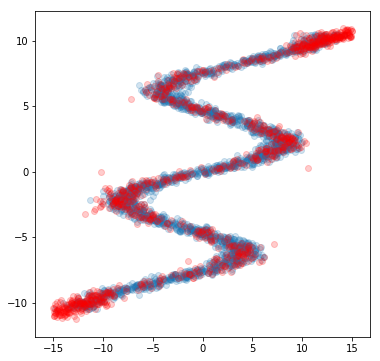

In [7]:
import matplotlib.pyplot as plt

test_data = torch.tensor(np.linspace(-15, 15, num=1000, dtype=np.float32), device=device).unsqueeze(1)
pi, mu, std = model(test_data)
samples = model.sample(pi=pi, mu=mu, std=std)
samples.detach().numpy()

plt.figure(figsize=[6, 6])
plt.scatter(D.y, D.x, alpha=0.2)
plt.scatter(test_data.detach().numpy(), samples.detach().numpy(), alpha=0.2, color='red')
plt.show()